## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai.conv_learner import *

In [3]:
PATH = Path('data')

In [4]:
IMPATH = PATH/'images'

In [5]:
list(PATH.iterdir())

[PosixPath('data/compressed'),
 PosixPath('data/labels.csv'),
 PosixPath('data/val_list.txt'),
 PosixPath('data/tmp'),
 PosixPath('data/test_list.txt'),
 PosixPath('data/images'),
 PosixPath('data/models'),
 PosixPath('data/Data_Entry_2017.csv'),
 PosixPath('data/train_list.txt')]

In [6]:
label_df = pd.read_csv(PATH/'Data_Entry_2017.csv')

In [7]:
label_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [8]:
labels = [' '.join(x.split('|')).replace('No Finding', '') for x in label_df['Finding Labels']]
fnames = label_df['Image Index'].values

In [9]:
pd.DataFrame({'fname': fnames, 'labels': labels}).to_csv(PATH/'labels.csv', index=False)

In [10]:
pd.read_csv(PATH/'labels.csv')

,fname,labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly Emphysema
2,00000001_002.png,Cardiomegaly Effusion
3,00000002_000.png,NaN
4,00000003_000.png,Hernia
5,00000003_001.png,Hernia
6,00000003_002.png,Hernia
7,00000003_003.png,Hernia Infiltration
8,00000003_004.png,Hernia
9,00000003_005.png,Hernia


## Multi-label versus single-label classification

In [11]:
from fastai.plots import *

In [12]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap='bone')
    ax.set_axis_off()
    return ax

Atelectasis Effusion Nodule


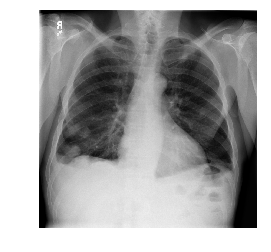

In [13]:
tmp_fname = next(IMPATH.iterdir())
print(labels[int(np.where(fnames == tmp_fname.name)[0])])
show_img(open_image(tmp_fname))

## Multi-label models for Planet dataset

In [43]:
from sklearn.metrics import fbeta_score, auc, roc_auc_score

In [14]:
def f1(preds, targs):
        return fbeta_score(targs, (preds>0.5), 1, average='samples')

In [44]:
def auc_metric(preds, targs):
        return auc(targs, preds, average='macro')

In [45]:
metrics=[auc_metric]

In [46]:
arch = resnet18

In [47]:
n = len(labels) # only if label_csv and files in folder match perfectly
# val_idxs = get_cv_idxs(n)

In [48]:
train_names = pd.read_table('data/train_list.txt', header=None, delimiter=' ')[0].values
val_names = pd.read_table('data/val_list.txt', header=None, delimiter=' ')[0].values
test_names = pd.read_table('data/test_list.txt', header=None, delimiter=' ')[0].values

fnames,y,classes = csv_source('', 'data/labels.csv', skip_header=True, suffix='', continuous=False, cat_separator=' ')

In [49]:
train_names_set = set(train_names)
train_idx = [i for i, a in enumerate(fnames) if a in train_names_set]

val_names_set = set(val_names)
val_idx = [i for i, a in enumerate(fnames) if a in val_names_set]

test_names_set = set(test_names)
test_idx = [i for i, a in enumerate(fnames) if a in test_names_set]

In [50]:
trn_fnames = np.array(['images/'+fnames[i] for i in train_idx])
trn_y = y[train_idx,:]

val_fnames = ['images/'+fnames[i] for i in val_idx]
val_y = y[val_idx, :]

tst_fnames = ['images/'+fnames[i] for i in test_idx]
tst_y = y[test_idx, :]

In [51]:
sz = 64
bs=128
nw=8

In [52]:
tfms = tfms_from_model(arch, sz, aug_tfms=[RandomFlip()], max_zoom=1.1)

In [53]:
datasets = ImageData.get_ds(FilesNhotArrayDataset, 
                            (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                            path=PATH, test=(tst_fnames,tst_y))

In [54]:
md = ImageClassifierData(PATH, datasets, bs=bs, num_workers=nw, classes=classes)

# md = ImageClassifierData.from_csv(PATH, folder='images', 
#                                         csv_fname='data/labels.csv', bs=bs, tfms=tfms, skip_header=True,
#                                         val_idxs=test_idx, num_workers=nw)

In [55]:
x,y = next(iter(md.trn_dl))

In [56]:
x.shape

torch.Size([128, 3, 64, 64])

In [57]:
y.shape

torch.Size([128, 14])

In [58]:
learn = ConvLearner.pretrained(arch, md, metrics=metrics)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.19748    0.242914   0.930411  


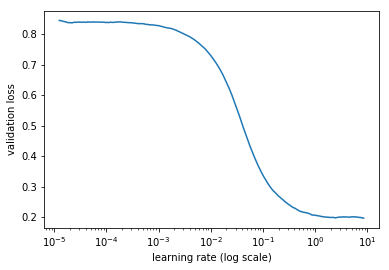

In [79]:
lrf=learn.lr_find()
learn.sched.plot()

In [59]:
lr = 1e-1

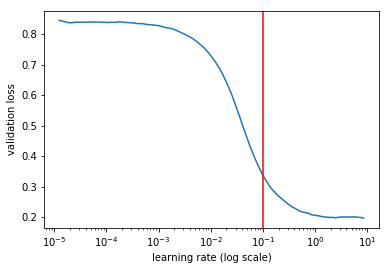

In [81]:
learn.sched.plot()
plt.axvline(lr, color='r')
plt.show()

In [60]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

TypeError: auc() got an unexpected keyword argument 'average'

In [33]:
tmp = learn.predict()

In [36]:
from sklearn.metrics import *

In [36]:
list(zip(md.classes, roc_auc_score(md.val_y, tmp, average=None)))

[('Atelectasis', 0.7169558510795117),
 ('Cardiomegaly', 0.7177725894564652),
 ('Consolidation', 0.724678015484351),
 ('Edema', 0.8337054951404727),
 ('Effusion', 0.7792175169982131),
 ('Emphysema', 0.7406223665136276),
 ('Fibrosis', 0.6940962873830301),
 ('Hernia', 0.7368378104271665),
 ('Infiltration', 0.6595734547864894),
 ('Mass', 0.6829351937371846),
 ('Nodule', 0.6249924209277742),
 ('Pleural_Thickening', 0.6721120151920531),
 ('Pneumonia', 0.6821998026503869),
 ('Pneumothorax', 0.7393302240451263)]

In [42]:
list(zip(md.classes, roc_auc_score(md.val_y, tmp, average=None)))

[('Atelectasis', 0.7687152273085052),
 ('Cardiomegaly', 0.8410977527847271),
 ('Consolidation', 0.7648472138662976),
 ('Edema', 0.8780551342210534),
 ('Effusion', 0.8475137031932829),
 ('Emphysema', 0.8023491575979338),
 ('Fibrosis', 0.7707538614152035),
 ('Hernia', 0.806713309267254),
 ('Infiltration', 0.6871987084572786),
 ('Mass', 0.7671262317264239),
 ('Nodule', 0.6555516082818874),
 ('Pleural_Thickening', 0.742407213757741),
 ('Pneumonia', 0.6978893274435848),
 ('Pneumothorax', 0.8181474244800904)]

In [37]:
list(zip(md.classes, roc_auc_score(md.val_y, tmp, average=None)))

[('Atelectasis', 0.7869887317816935),
 ('Cardiomegaly', 0.8854017830496246),
 ('Consolidation', 0.7810246562987393),
 ('Edema', 0.8888296164080917),
 ('Effusion', 0.8683543517108849),
 ('Emphysema', 0.8666470597760865),
 ('Fibrosis', 0.7861191137482193),
 ('Hernia', 0.8291732563426035),
 ('Infiltration', 0.6992133566356218),
 ('Mass', 0.8076255904991878),
 ('Nodule', 0.7017474662337837),
 ('Pleural_Thickening', 0.7642689749737707),
 ('Pneumonia', 0.7177621568283888),
 ('Pneumothorax', 0.8558863609003161)]

In [38]:
roc_auc_score(md.val_y, tmp, average='macro')

0.8027887482276437

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('init_pre')

In [ ]:
learn.load('init_pre')

In [30]:
lrs = np.array([lr/9,lr/3,lr])

In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.166669   0.160115   0.94941   
    1      0.161635   0.15598    0.949639                    
    2      0.158357   0.154837   0.949751                    
    3      0.157483   0.154123   0.949834                    
    4      0.156702   0.152511   0.949811                    
    5      0.152583   0.151585   0.949901                    
    6      0.148743   0.151399   0.94999                     



[array([0.1514]), 0.9499898066998719]

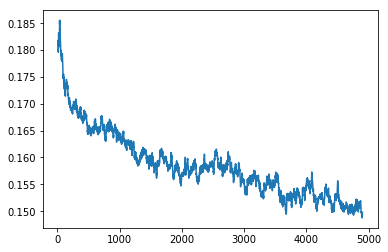

In [32]:
learn.sched.plot_loss()

In [ ]:
learn.save('init_all')

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}_all')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

In [ ]:
list(zip(data.classes, roc_auc_score(data.val_y, preds, average=None)))

In [ ]:
f2(preds,y)

### End